In [1]:
import re
import json
import pickle
import numpy as np
import pandas as pd
%matplotlib inline

import matplotlib.pyplot as plt

In [2]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import roc_auc_score

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

In [3]:
def clean_str(s):
    return re.sub(r'\s', '', s)

def are_equal(a , b):
    return clean_str(a) == clean_str(b)

def a_in_b(a , b):
    return clean_str(a) in clean_str(b)

def add_cols (df, columns, default_value = 0):
    for k, e in enumerate(columns):
        i = common_data([e], df.columns, are_equal)

        if i == -1:
            df[e] = default_value
    return df

def common_data(list1, list2, comparisonf): 
    result = -1
  
    for k, x in enumerate(list1): 
        for y in list2: 
            
            if comparisonf(x,y):
                result = k
                return result  
                  
    return result

def prepare_data(df, feat2dummie, cols_to_pow, columns, drop_first = True, max_pow = 3):
    
    for i in feat2dummie:
        one_hot = pd.get_dummies(df[i], prefix=i, drop_first=drop_first)
        df = df.drop(i,axis = 1)
        df = df.join(one_hot)

    is_recid, is_violent_recid = df['is_recid'], df['is_violent_recid']

    columns_to_drop = ['is_recid', 'is_violent_recid']
    df = df.drop(columns_to_drop, axis=1)
    
    dft = df.copy()

    for k,i in enumerate(cols_to_pow):
        for j in range(1, max_pow):
            dft[i+str(j+1)] = pow(df[i], j+1)
    
    dft = add_cols(dft, columns)
    
    return dft, is_recid, is_violent_recid


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [4]:
pd.set_option('display.max_columns', None)

In [5]:
data_folder = './data'
model_folder = './model'
interpretation_result_folder = './audit_result'

train_dataset = 'compas_processed_with_results.xlsx'
train_dataset_raw = 'train_compas_processed.xlsx'

validate_dataset = 'validate_compas_processed.xlsx'
model_colums_sample = 'model_colums_sample.xlsx'

model_file_name = 'rf_recidivism_prediction.sav'


interpretation_tree_filename = 'forest_tree_interpretation'

### Load data

In [6]:
train_df_result = pd.read_excel (data_folder+'/'+train_dataset)
train_df = pd.read_excel (data_folder+'/'+train_dataset_raw)

validate_df_init = pd.read_excel (data_folder+'/'+validate_dataset)

#train_df = train_df_init
validate_df = validate_df_init

In [7]:
columns = pd.read_excel (data_folder+'/'+model_colums_sample).columns

In [8]:
train_df.shape

(8918, 14)

In [9]:
validate_df.shape

(470, 14)

#### Prepare data for prediction

In [10]:
max_pow = 3
drop_first = True

feat2dummie = ['sex','age_cat','race','c_charge_degree','c_cat','weapon_firearm']
cols_to_pow = ['age','decile_score','priors_count','juv_count']

validate_df_processed, is_recid, is_violent_recid = prepare_data(validate_df, feat2dummie, cols_to_pow, columns, drop_first = True, max_pow = 3)

### Load model

In [11]:
rfc = pickle.load(open(model_folder+'/'+model_file_name, 'rb'))

C:\Users\Fernando\Anaconda3\lib\site-packages\sklearn\base.py:311: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.21.0 when using version 0.19.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\Fernando\Anaconda3\lib\site-packages\sklearn\base.py:311: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.21.0 when using version 0.19.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [12]:
train_df['is_recid'] = train_df_result['is_recid']
train_df['prediction'] = train_df_result['prediction']

In [13]:
train_df.head(10)

sex  age          age_cat              race  decile_score  priors_count  \
0    Male   45  Greater than 45         Caucasian             5            12   
1  Female   26          25 - 45  African-American             8             0   
2    Male   47  Greater than 45         Caucasian             1             1   
3    Male   60  Greater than 45         Caucasian             1             1   
4    Male   39          25 - 45         Caucasian             2             2   
5    Male   43          25 - 45  African-American             5             9   
6    Male   22     Less than 25             Other             3             3   
7    Male   57  Greater than 45          Hispanic             1             1   
8    Male   32          25 - 45         Caucasian             5             6   
9  Female   40          25 - 45  African-American             5             2   

   days_b_screening_arrest  c_days_from_compas c_charge_degree  is_recid  \
0                       -1                   0               F         1   
1                       -1                   1               M         0   
2                        0                   1               M         0   
3                       -1                   1               M         0   
4                      -13                  13               F         1   
5                       -1                   1               F         0   
6                       -1                   1               F         0   
7                        0                   0               F         0   
8                      -29                  30               M         0   
9                       -1                   1               M         0   

   is_violent_recid  juv_count      c_cat  weapon_firearm  prediction  
0                 0          1  no charge           False           0  
1                 0          0      other           False           0  
2                 0          0    battery           False           0  
3                 0          0    driving           False           0  
4                 0          0      other           False           0  
5                 0          1    battery           False           0  
6                 0          1  no charge           False           1  
7                 0          0    driving           False           0  
8                 0          0    battery           False           0  
9                 0          0      other           False           0

Confusion matrix, without normalization
[[5285  609]
 [1747 1277]]
Normalized confusion matrix
[[0.89667458 0.10332542]
 [0.57771164 0.42228836]]


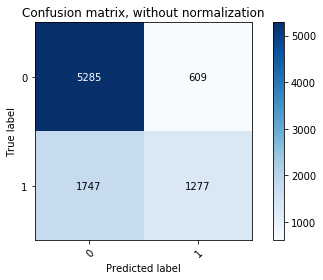

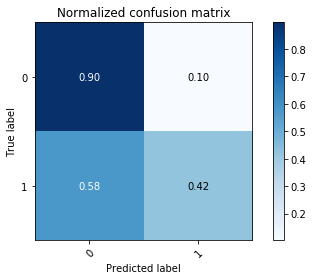

In [14]:
# Plot non-normalized confusion matrix
class_names = np.array(['0','1'])
plot_confusion_matrix(train_df['is_recid'], train_df['prediction'], classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(train_df['is_recid'], train_df['prediction'], classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

## 1. Bias detection in the data

Required data preprocessing. True labels should be in column `label_value`, predicted labels in column `score`. Any other column passed to `BiasDetection` class will be considered as protected property and statistical tests will be run on it

In [15]:
bias_df = train_df[['prediction', 'is_recid', 'race', 'sex', 'age_cat']]
bias_df = bias_df.rename(columns={'is_recid':'label_value', 'prediction':'score'})
bias_df.head()

score  label_value              race     sex          age_cat
0      0            1         Caucasian    Male  Greater than 45
1      0            0  African-American  Female          25 - 45
2      0            0         Caucasian    Male  Greater than 45
3      0            0         Caucasian    Male  Greater than 45
4      0            1         Caucasian    Male          25 - 45

In [16]:
import bias_detection.bias_detection as bd

bias = bd.BiasDetection(bias_df)

### Analysing dataset bias

First of all, we check the bias of a model and a dataset itself. For the dataset bias, we require that protected properties of an individual do not have a strong influence on the decision. That is, the library splits the dataset into groups based on protected property. If the percentage of positive labels is beyond [20% neighborhood](https://en.wikipedia.org/wiki/Disparate_impact) for all groups, then it is deemed to have a bias in respect to that protected property.

In [17]:
import pprint

dataset_bias_info = bias.check_dataset_bias()

pp = pprint.PrettyPrinter()
pp.pprint(dataset_bias_info)

{'details': {'age_cat': {'fair': False,
                         'ratios': {'25 - 45': 0.346078431372549,
                                    'Greater than 45': 0.24016780283167277,
                                    'Less than 25': 0.41915227629513346}},
             'race': {'fair': False,
                      'ratios': {'African-American': 0.4036429053294356,
                                 'Asian': 0.17777777777777778,
                                 'Caucasian': 0.2863636363636364,
                                 'Hispanic': 0.25224071702944945,
                                 'Native American': 0.2692307692307692,
                                 'Other': 0.2504638218923933}},
             'sex': {'fair': True,
                     'ratios': {'Female': 0.24742268041237114,
                                'Male': 0.3629681978798587}}},
 'fair': False}


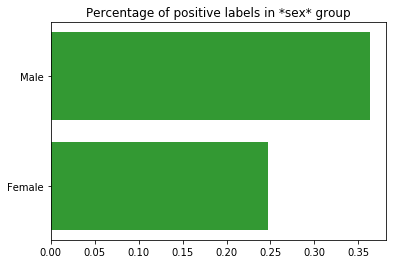

In [18]:
bias.plot_dataset_bias(dataset_bias_info, 'sex')

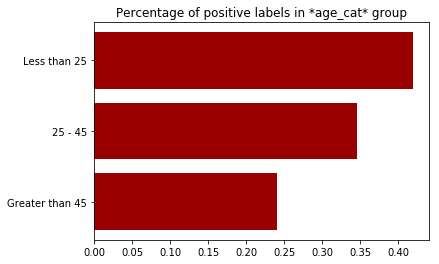

In [19]:
bias.plot_dataset_bias(dataset_bias_info, 'age_cat')

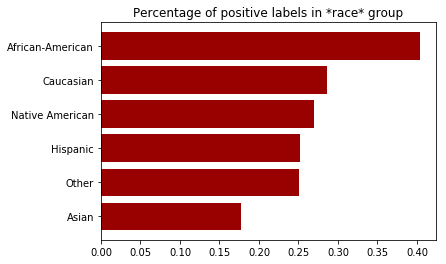

In [20]:
bias.plot_dataset_bias(dataset_bias_info, 'race')

### Analysing model bias

Now we analise the bias of the model itself. We can get bias summary with reqired level of detalization with `get_model_fairness` function. Available levels are `model`, `attribute`, and `value`. Each gives overview of fairness on model, attribute, and groups within each attribute (all kind of races) respectively

In [21]:
bias.get_model_fairness(level='model')

model_id, score_thresholds 1 {'rank_abs': [1886]}
get_disparity_major_group()


{'Unsupervised Fairness': False,
 'Supervised Fairness': False,
 'Overall Fairness': False}

In [22]:
bias.get_model_fairness(level='attribute')

model_id, score_thresholds 1 {'rank_abs': [1886]}
get_disparity_major_group()


model_id score_threshold attribute_name  Statistical Parity  Impact Parity  \
0         1      binary 0/1        age_cat               False          False   
1         1      binary 0/1           race               False          False   
2         1      binary 0/1            sex               False          False   

   FDR Parity  FPR Parity  FOR Parity  FNR Parity  TPR Parity  TNR Parity  \
0       False       False       False       False       False        True   
1       False       False       False       False       False        True   
2        True       False       False       False       False        True   

   NPV Parity  Precision Parity  TypeI Parity  TypeII Parity  Equalized Odds  \
0        True              True         False          False           False   
1        True             False         False          False           False   
2        True              True         False          False           False   

   Unsupervised Fairness  Supervised Fairness  
0                  False                False  
1                  False                False  
2                  False                False

In [23]:
bias.get_model_fairness(level='value')

model_id, score_thresholds 1 {'rank_abs': [1886]}
get_disparity_major_group()


model_id score_threshold     k attribute_name   attribute_value       tpr  \
0          1      binary 0/1  1886           race  African-American  0.519220   
1          1      binary 0/1  1886           race             Asian  0.375000   
2          1      binary 0/1  1886           race         Caucasian  0.286848   
3          1      binary 0/1  1886           race          Hispanic  0.258883   
4          1      binary 0/1  1886           race   Native American  0.571429   
5          1      binary 0/1  1886           race             Other  0.251852   
6          1      binary 0/1  1886            sex            Female  0.285088   
7          1      binary 0/1  1886            sex              Male  0.446651   
8          1      binary 0/1  1886        age_cat           25 - 45  0.436261   
9          1      binary 0/1  1886        age_cat   Greater than 45  0.251092   
10         1      binary 0/1  1886        age_cat      Less than 25  0.489388   

         tnr       for       fdr       fpr       fnr       npv  precision  \
0   0.833333  0.280833  0.321689  0.166667  0.480780  0.719167   0.678311   
1   1.000000  0.119048  0.000000  0.000000  0.625000  0.880952   1.000000   
2   0.945405  0.232361  0.321716  0.054595  0.713152  0.767639   0.678284   
3   0.941781  0.209770  0.400000  0.058219  0.741117  0.790230   0.600000   
4   0.947368  0.142857  0.200000  0.052632  0.428571  0.857143   0.800000   
5   0.970297  0.204868  0.260870  0.029703  0.748148  0.795132   0.739130   
6   0.954578  0.197576  0.326425  0.045422  0.714912  0.802424   0.673575   
7   0.878855  0.264028  0.322504  0.121145  0.553349  0.735972   0.677496   
8   0.886057  0.251899  0.330435  0.113943  0.563739  0.748101   0.669565   
9   0.974465  0.195442  0.243421  0.025535  0.748908  0.804558   0.756579   
10  0.827027  0.308214  0.328767  0.172973  0.510612  0.691786   0.671233   

      pp    pn       ppr     pprev   fp    fn    tn    tp  group_label_pos  \
0   1374  3073  0.728526  0.308972  442   863  2210   932             1795   
1      3    42  0.001591  0.066667    0     5    37     3                8   
2    373  2707  0.197773  0.121104  120   629  2078   253              882   
3     85   696  0.045069  0.108835   34   146   550    51              197   
4      5    21  0.002651  0.192308    1     3    18     4                7   
5     46   493  0.024390  0.085343   12   101   392    34              135   
6    193  1650  0.102333  0.104721   63   326  1324   130              456   
7   1693  5382  0.897667  0.239293  546  1421  3961  1147             2568   
8   1150  3950  0.609756  0.225490  380   995  2955   770             1765   
9    152  1755  0.080594  0.079706   37   343  1412   115              458   
10   584  1327  0.309650  0.305599  192   409   918   392              801   

    group_label_neg  group_size  total_entities      prev  ppr_disparity  \
0              2652        4447            8918  0.403643       1.000000   
1                37          45            8918  0.177778       0.002183   
2              2198        3080            8918  0.286364       0.271470   
3               584         781            8918  0.252241       0.061863   
4                19          26            8918  0.269231       0.003639   
5               404         539            8918  0.250464       0.033479   
6              1387        1843            8918  0.247423       0.113999   
7              4507        7075            8918  0.362968       1.000000   
8              3335        5100            8918  0.346078       1.000000   
9              1449        1907            8918  0.240168       0.132174   
10             1110        1911            8918  0.419152       0.507826   

    pprev_disparity  precision_disparity  fdr_disparity  for_disparity  \
0          1.000000             1.000000       1.000000       1.000000   
1          0.215769             1.474249       0.000000       0.423909   
2          0.391957             0.

Below we can see some useful visualization of fairness for `value` level with `plot_fairness` function. Red and green colors indicates which values are classified fairly by model and which aren't. There are two modes for visualization: with absolute and relative values respectively

model_id, score_thresholds 1 {'rank_abs': [1886]}
get_disparity_major_group()


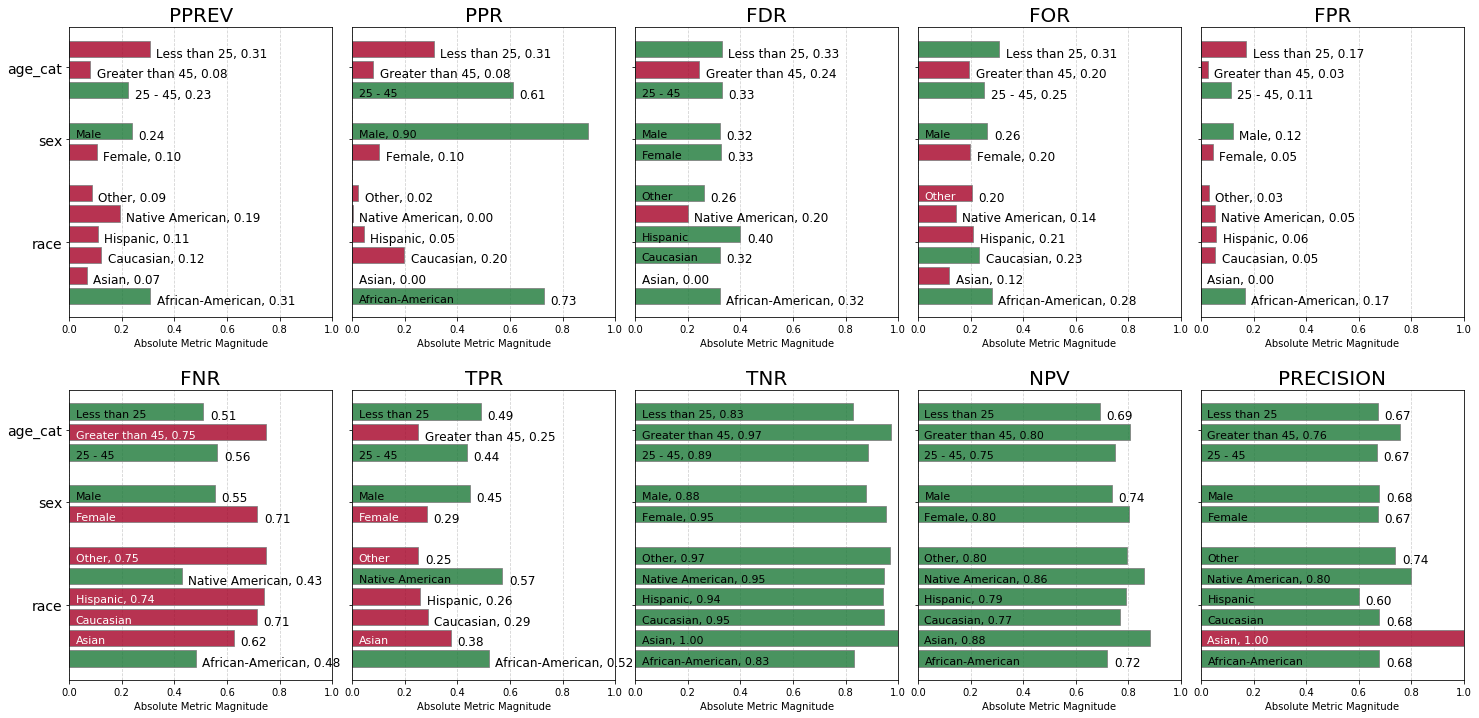

In [24]:
fg = bias.plot_fairness(is_absolute=True)

model_id, score_thresholds 1 {'rank_abs': [1886]}
get_disparity_major_group()


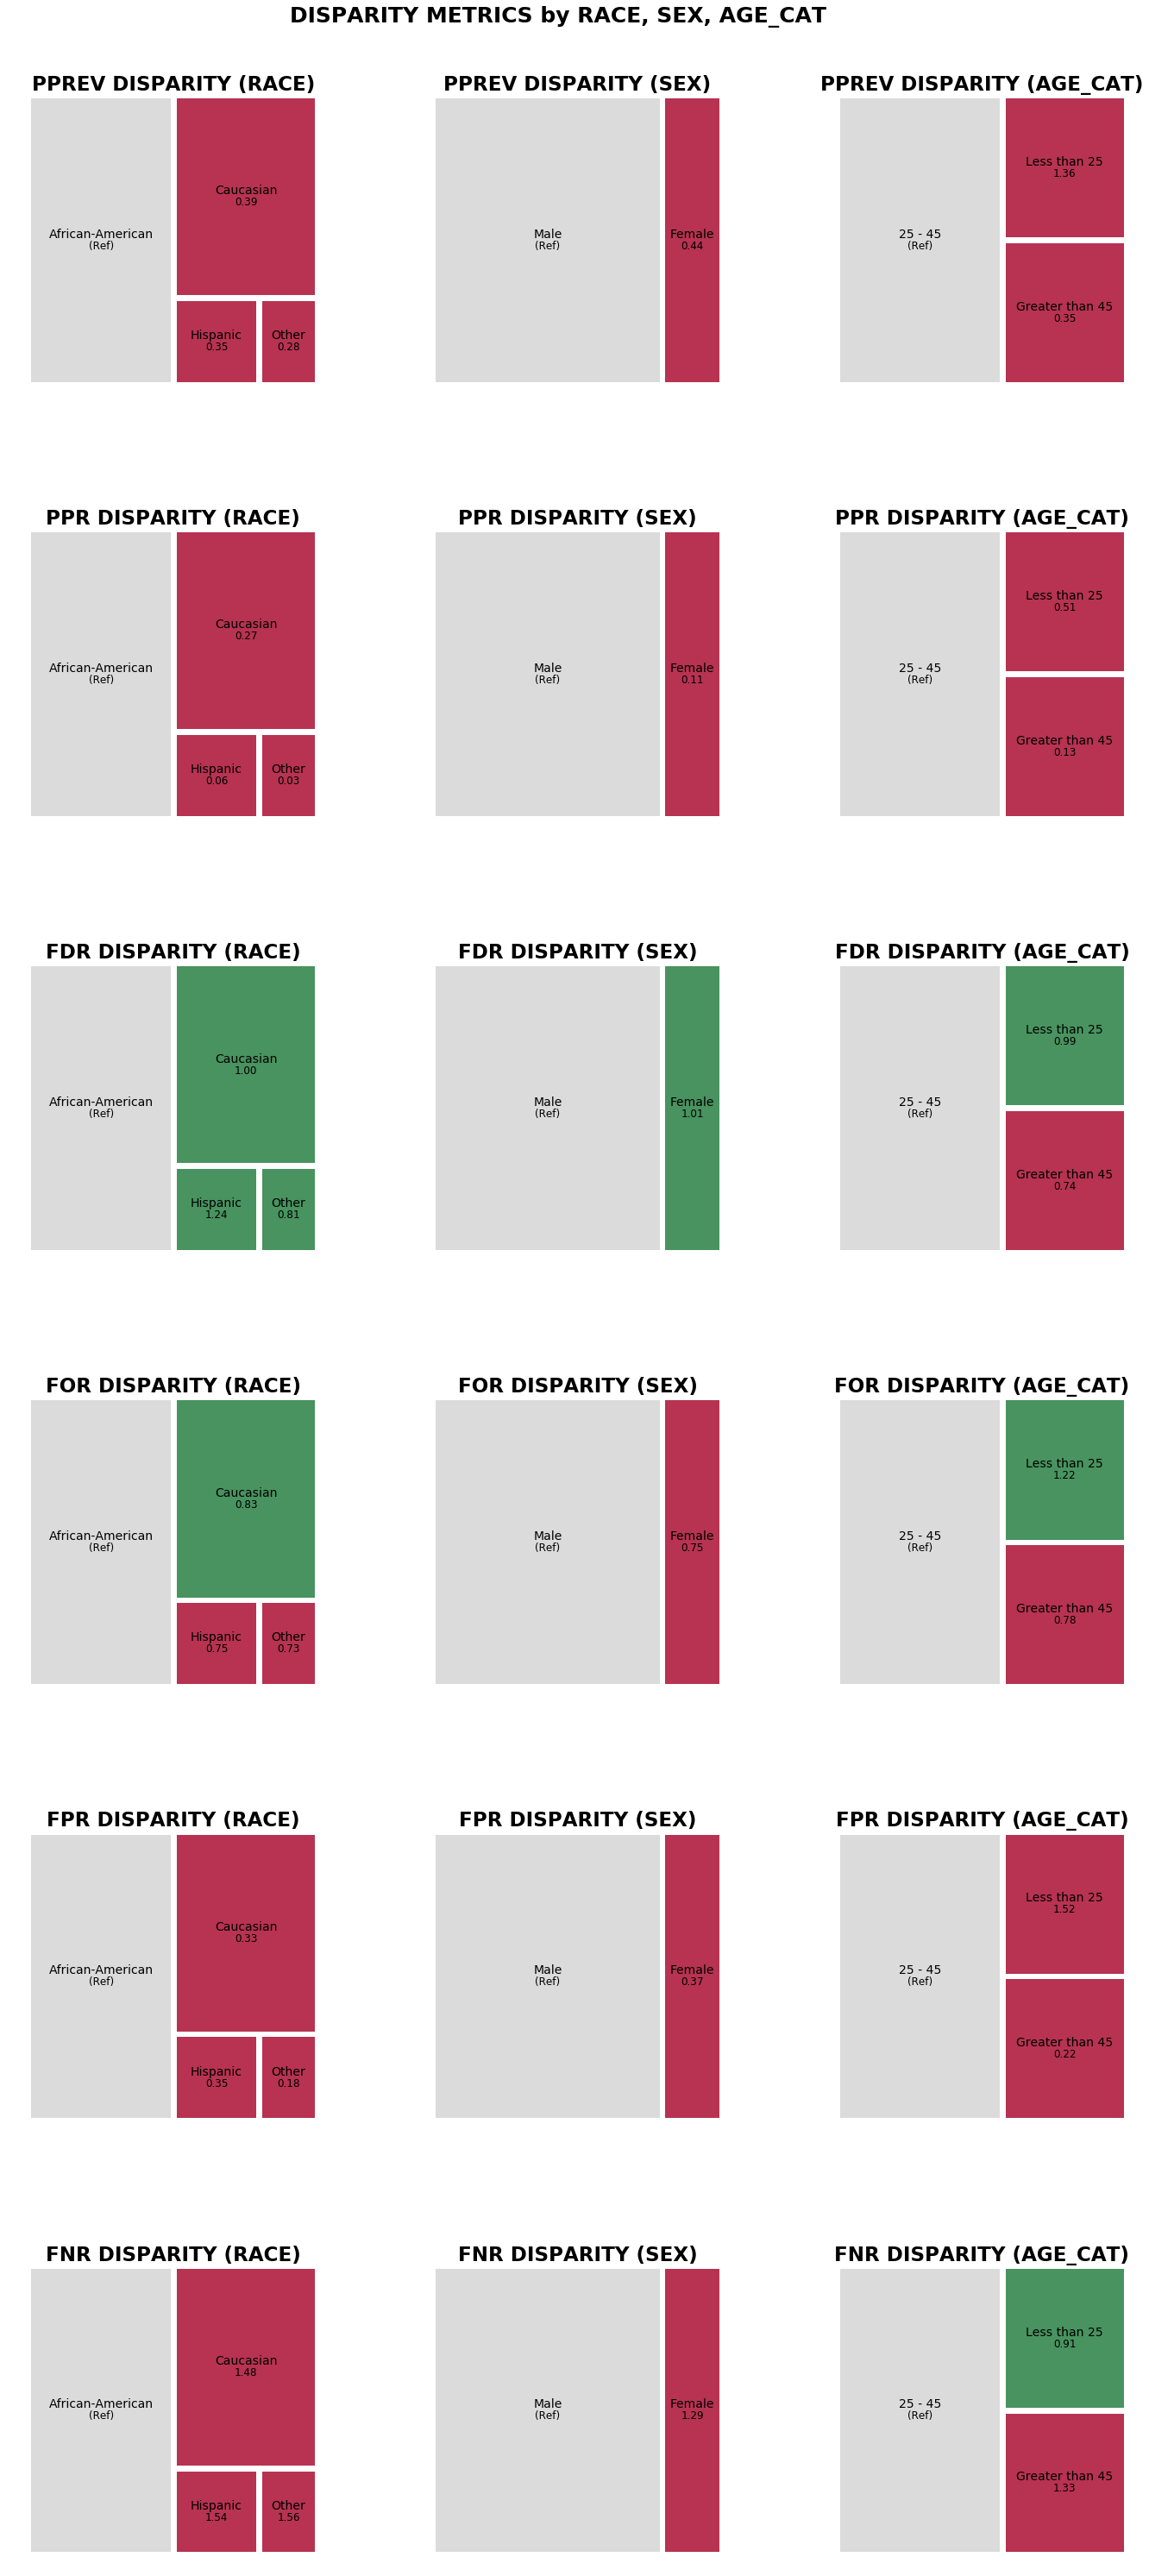

In [25]:
fg = bias.plot_fairness(is_absolute=False)

## 2. Feature selection from the data

In [65]:
from feature_selection.feature_selector import FeatureSelector

### Loading splitted training and testing data

In [66]:
train_x = pd.read_csv(data_folder + '/' + 'train_x.csv')
test_x = pd.read_csv(data_folder + '/' + 'test_x.csv')

train_y = pd.read_csv(data_folder + '/' + 'train_y.csv')
test_y = pd.read_csv(data_folder + '/' + 'test_y.csv')

### Initializng FeatureSelector with RF model and data

In [67]:
feature_selector = FeatureSelector(rfc, train_x, test_x, train_y, test_y, train_x.columns)

Initiating FeatureSelector...
Done.
-----------------------------------
Creating interpretator for model
Done.
-----------------------------------
Building SHAP explainer for Tree Model
Done.
-----------------------------------
Computing SHAP values for first 100 test samples...
Attention! For a large dataset this procedure could take a while.
Done.


### Calculate and plot feature importance in the output of RF model

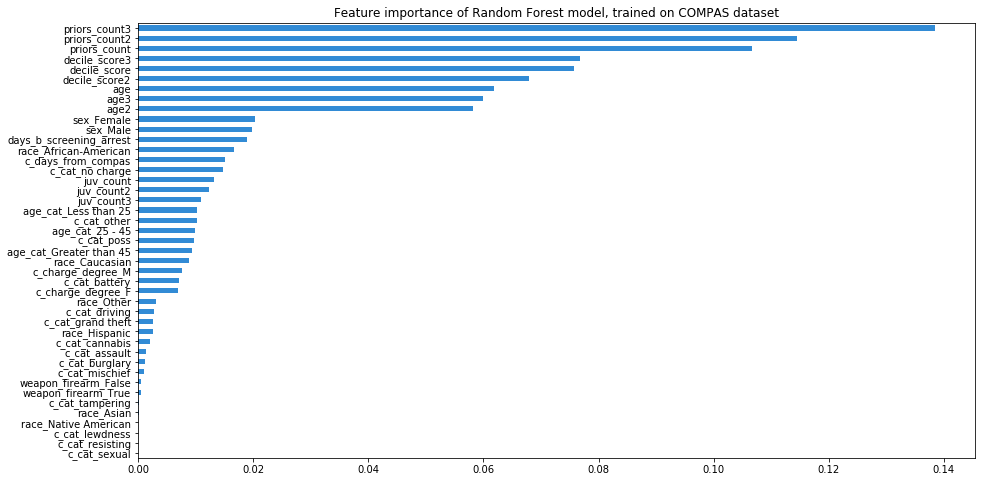

In [68]:
feature_selector.featureImportance()

### Calculate and plot partial dependence of different features with the output of the model

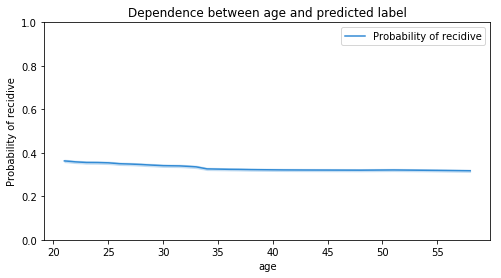

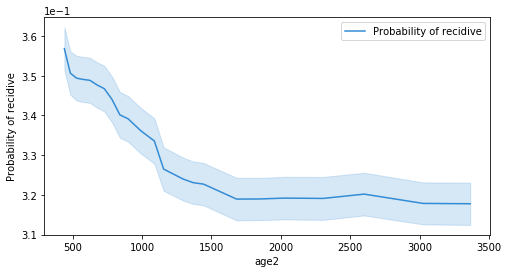

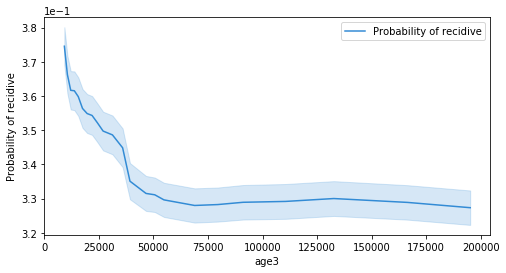

In [69]:
feature_selector.partialDependence(['age', 'age2', 'age3'])

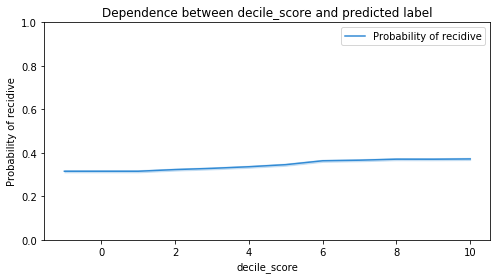

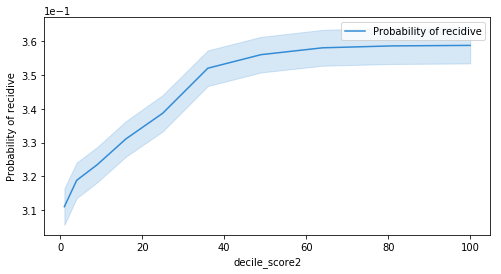

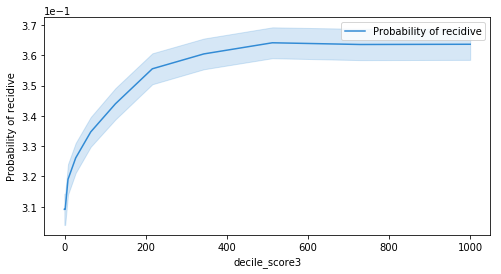

In [70]:
feature_selector.partialDependence(['decile_score', 'decile_score2', 'decile_score3'])

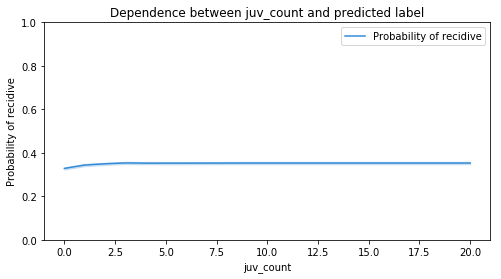

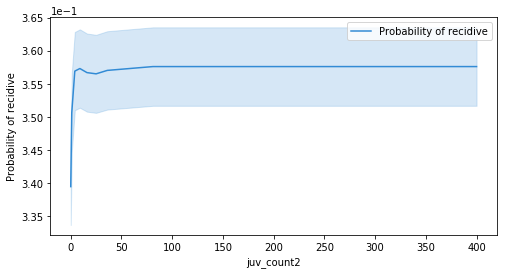

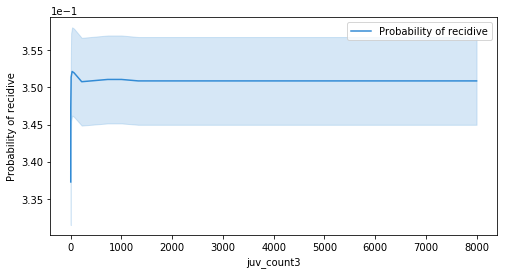

In [71]:
feature_selector.partialDependence(['juv_count', 'juv_count2', 'juv_count3'])

### Calculating SHAP values 

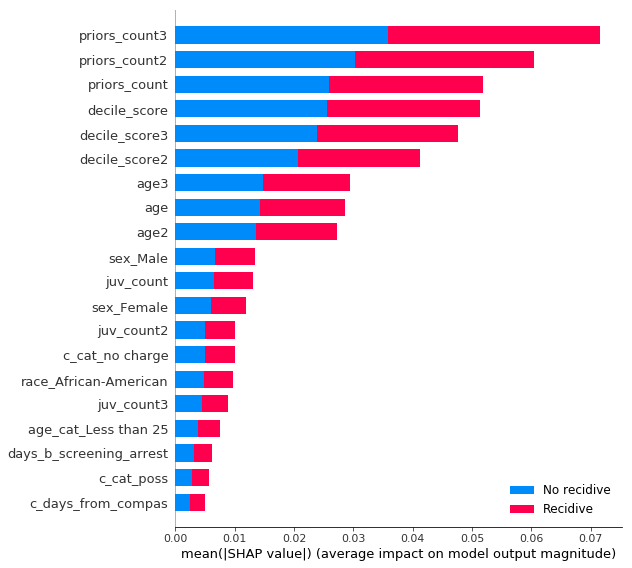

In [72]:
feature_selector.shapSummaryPlot()

## 3. Result interpretability

#### Create and plot tree interpretation

In [30]:
# type(train_df['prediction'])
# np.unique(train_df['prediction'])

array([0, 1])

In [34]:
from result_interpretation import ModelInterpreter

model_interpreter = ModelInterpreter(rfc, 
                                     train_df_result.drop(['is_recid','prediction'], axis=1), 
                                     train_df_result['is_recid'])

In [36]:
model_interpreter.explain_instance(train_df_result.drop(['is_recid','prediction'], axis=1).iloc[0, :])

In [38]:
model_interpreter.print_instance_tree_interpretation(train_df_result.drop(['is_recid','prediction'], axis=1).iloc[[0]])

                         value_variable  contribution_variable
sex_Female                          0.0                  0.005
sex_Male                            1.0                  0.005
c_days_from_compas                  1.0                  0.004
race_Caucasian                      1.0                  0.003
c_cat_no charge                     0.0                  0.002
days_b_screening_arrest            -1.0                  0.002
age_cat_Greater than 45             0.0                  0.002
race_Other                          0.0                  0.001
age_cat_25 - 45                     1.0                  0.001
c_cat_mischief                      0.0                 -0.000
c_cat_lewdness                      0.0                  0.000
c_cat_cannabis                      0.0                 -0.000
c_cat_resisting                     0.0                  0.000
c_cat_assault                       0.0                  0.000
c_charge_degree_M                   1.0                

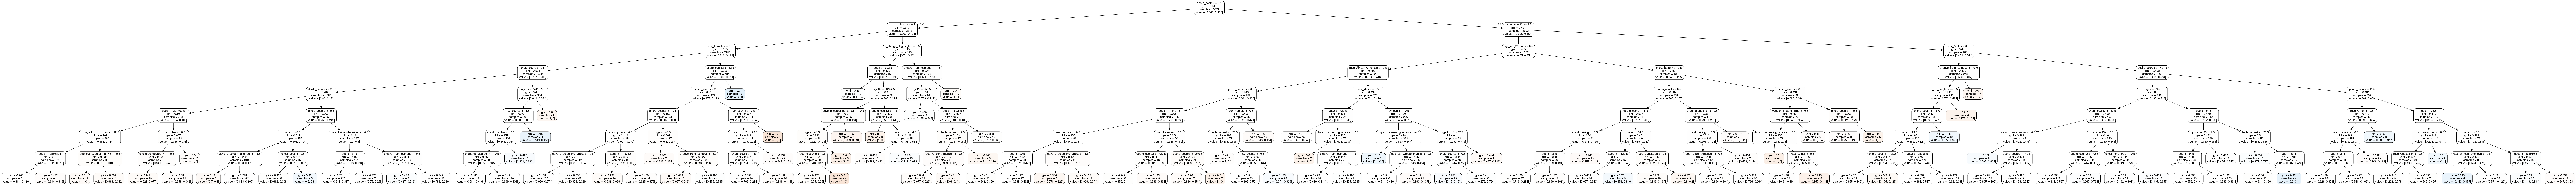

In [39]:
interpretation_plots = model_interpreter.visualize_tree([rfc.estimators_[2]], columns)

from IPython.display import Image
Image(filename = interpretation_plots[0])